In [1]:
import numpy as np  # Importing Some Libraries
import matplotlib.pyplot as plt

from typing import Tuple
from typing import List

## Defining some Utility functions that will help us in this assingment

In [2]:
SRC = (0, 0)  # Convention we took for the source


def gen_mics(
    Nmics: int, pitch: float, src: Tuple[float]
) -> List[
    float
]:  # Generating all the mics along y-axis and centering them about src (Taking pitch and number of mics as parameters)
    if Nmics % 2 == 0:  # No mic at src
        mics = list(
            np.linspace(src[1] - (Nmics // 2) * pitch, src[1] - pitch, Nmics // 2)
        ) + list(np.linspace(src[1] + pitch, src[1] + (Nmics // 2) * pitch, Nmics // 2))
    else:  # Mic at src
        mics = list(
            np.linspace(
                src[1] - (Nmics // 2) * pitch, src[1] + (Nmics // 2) * pitch, Nmics
            )
        )

    return mics

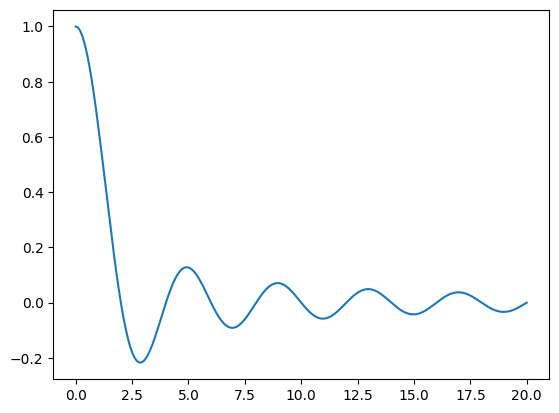

In [4]:
def wsrc(
    t: List[int], SincP: float
) -> List[float]:  # Generating the equation of the waveform
    return np.sinc(SincP * t)


dist_per_samp_ex = 0.1
Nsamp_ex = 200
Sincp_ex = 0.5
t_ex = np.linspace(0, dist_per_samp_ex * Nsamp_ex, Nsamp_ex)
y = wsrc(t_ex, Sincp_ex)
plt.figure("General Estimate")
plt.plot(t_ex, y)  # Plotting a sample

In [5]:
def euc_dist(
    p1: Tuple[float], p2: Tuple[float]
) -> (
    float
):  # To calculate the euclidean distance between two points (Will be used in dist() function)
    return ((p1[1] - p2[1]) ** 2 + (p1[0] - p2[0]) ** 2) ** 0.5


def dist(
    src: Tuple[float], obs: Tuple[float], mic: Tuple[float]
) -> float:  # To get the travel distance from src to mic via reflection from obs
    d1 = euc_dist(src, obs)  # distance from src to obs
    d2 = euc_dist(obs, mic)  # distance from obs to mic
    return d1 + d2

## Generating Mic Array Output

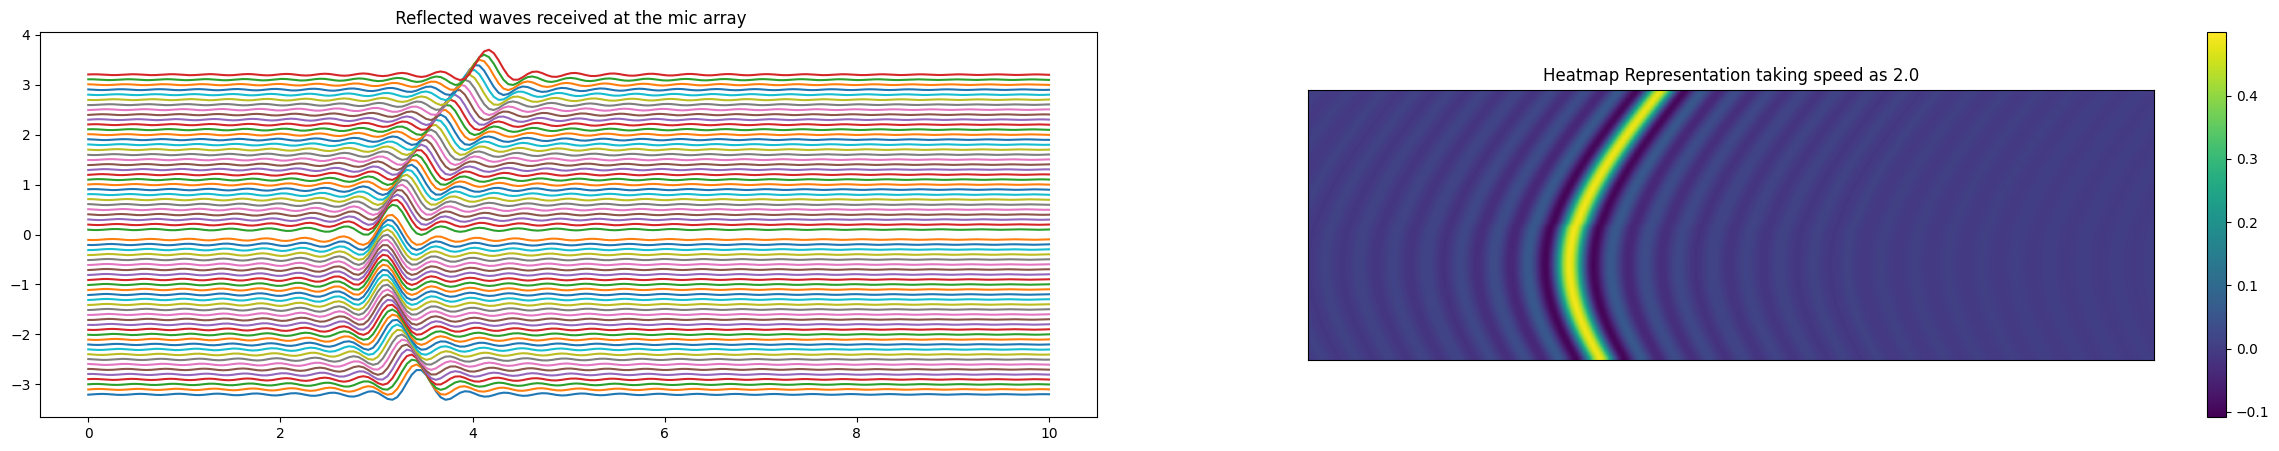

In [14]:
NMICS = 64  # Providing some sample parameters (we can play around with them to observe various results)
SAMPLE_NO = 200
PITCH = 0.1
SPEED = 2.0
OBS_LOC = (3, -1)
SINCP = 5
DIST_PER_SAMP = 0.1


def ultrasound(
    Nmics: int,
    Nsamp: int,
    pitch: float,
    C: float,
    obs: Tuple[float],
    custom_sincp: float,
    dist_per_samp: float,
    show: bool = True,
) -> List[float]:  # Function to generate the desired plots
    custom_t = np.linspace(0, dist_per_samp * Nsamp / C, Nsamp)  # Time samples

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))
        ax1.set_title(" Reflected waves received at the mic array")
        ax2.set_title(f"Heatmap Representation taking speed as {C}")

        ax2.set_xticks([])
        ax2.set_yticks([])

    li = []
    mics = gen_mics(Nmics, pitch, SRC)
    for i in mics:
        delay = dist(
            (0, 0), obs, (0, i)
        )  # Finding the distance travelled by reflected wave to mic
        ref_waves = (
            wsrc(custom_t - delay / C, custom_sincp) * 0.5
        )  # Waveform captured by mic
        li.append(ref_waves)

        if show:
            ax1.plot(
                custom_t, ref_waves + i
            )  # Plotting reflected wave captured by mic i

    li = list(reversed(li))

    if show:
        c = ax2.imshow(li, interpolation="gaussian")  # Plotting the heatmap
        plt.colorbar(c)
    return li


li = ultrasound(NMICS, SAMPLE_NO, PITCH, SPEED, OBS_LOC, SINCP, DIST_PER_SAMP, True)

## DAS Algorithm:
Let us now apply the Delay And Sum algorithm with the 2 datasets provided

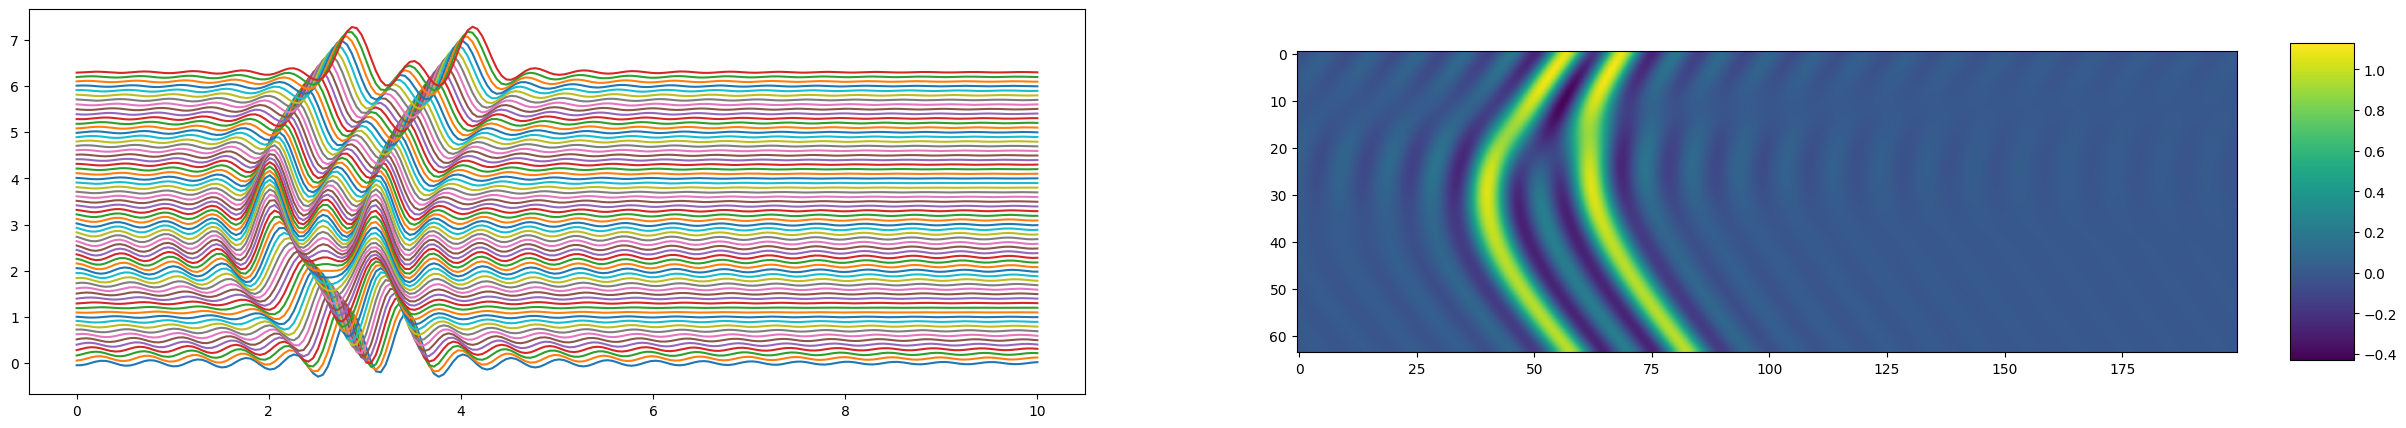

In [16]:
data2 = np.loadtxt("rx2.txt")  # Loading rx2.txt

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(30, 5)
)  # Displaying the mic output and its corresponding heatmap

custom_t = np.linspace(0, DIST_PER_SAMP * SAMPLE_NO / SPEED, SAMPLE_NO)
for i in range(len(data2)):
    ax1.plot(custom_t, data2[i] + 0.1 * i)
c = ax2.imshow(data2, interpolation="gaussian", cmap="viridis")
plt.colorbar(c, fraction=0.06, aspect=5)

Doing the same for rx3.txt

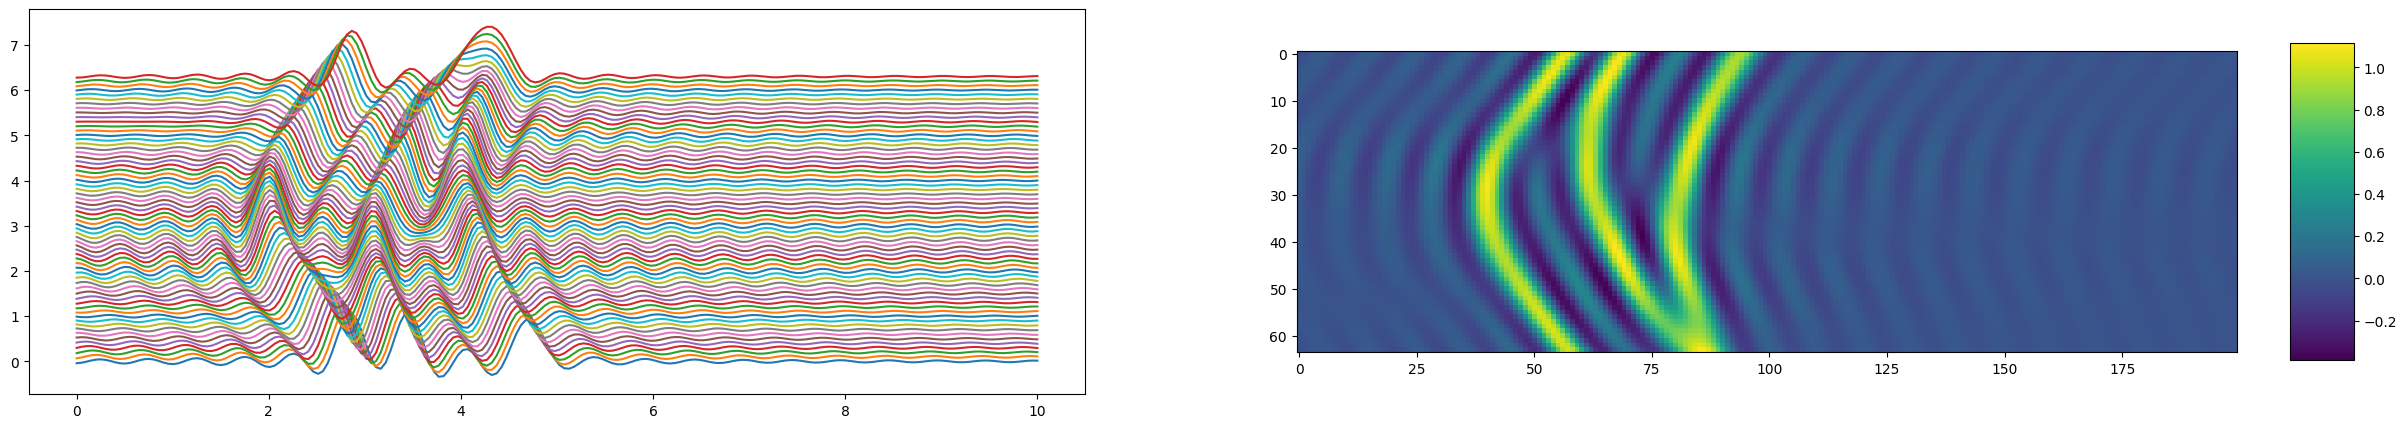

In [18]:
data3 = np.loadtxt("rx3.txt")  # Loading rx3.txt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 5))
for i in range(len(data3)):
    ax1.plot(custom_t, data3[i] + 0.1 * i)
c = ax2.imshow(data3, interpolation="nearest", cmap="viridis")
plt.colorbar(c, fraction=0.06, aspect=5)

Now that we have visualised the dataset, let us use it to figure out the obstacle location

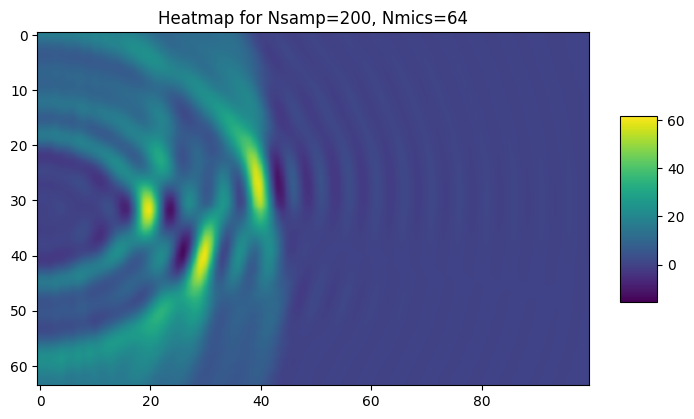

In [19]:
def reconstruct(
    Nmics: int,
    pitch: float,
    data: List[float],
    Nsamp: int,
    dist_per_samp: float,
    C: float,
) -> None:  # Function to generate the heatmap
    custom_t = np.linspace(0, dist_per_samp * Nsamp / C, Nsamp)  # Time samples List

    mics = gen_mics(64, pitch, SRC)  # Generating mics along y axis
    li = []

    for i in range(len(mics)):
        lj = []
        for j in range(
            Nsamp // 2
        ):  # Why I have taken Nsamp/2 is answered in the questions section
            coord = (
                custom_t[j] * C,
                mics[i],
            )  # Getting space coordinates of the supposed obstacle from our grid (Time Samples v/s Mic Location)

            val = 0
            for k in range(32 - Nmics // 2, 32 + Nmics // 2):
                delay = round(
                    dist((0, 0), coord, (0, mics[k])) / dist_per_samp
                )  # Finding out which sample to take based on the delay
                if delay >= Nsamp:
                    continue
                val += data[k][delay]  # Adding the particular sample of the mic

            lj.append(val)
        li.append(lj)

    li = list(reversed(li))

    plt.figure(figsize=(8, 16))  # Plotting the heatmap
    plt.title(f"Heatmap for Nsamp={Nsamp}, Nmics={Nmics}")
    c = plt.imshow(li, cmap="viridis", interpolation="gaussian")
    plt.colorbar(c, fraction=0.06, aspect=5)


reconstruct(64, 0.1, data3, 200, 0.1, 2)

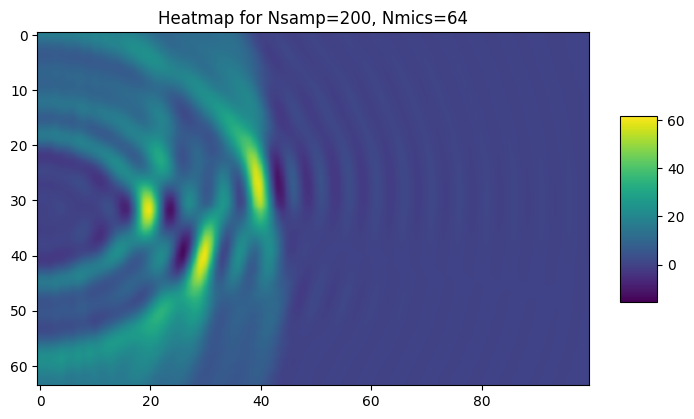

In [20]:
reconstruct(64, 0.1, data3, 200, 0.1, 2)  # Trying the same for rx3.txt

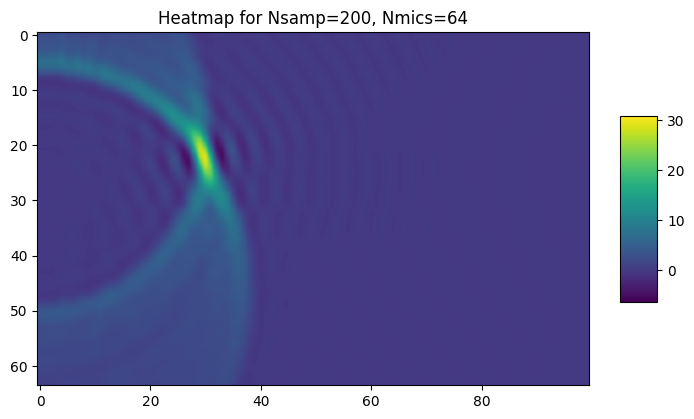

In [21]:
reconstruct(
    64, 0.1, li, 200, 0.1, 2
)  # Trying DAS algo with the dataset generated by the first part of the assignment (generating waveform for obstacle at (3,-1))

## QUESTIONS

1) Generating the two pulses

To get the following pulses, We just have to change the dilation factor and tweak the sampling

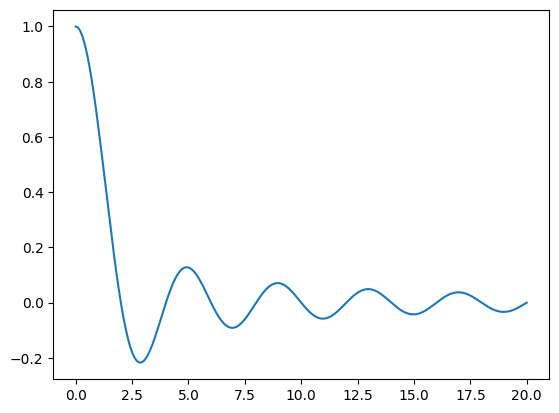

In [22]:
custom_sincp = 0.5  # Changing sincp to 0.5
custom_nsamp = 100
dist_per_samp = 0.1
Nsamp = 200

custom_t = np.linspace(0, dist_per_samp * Nsamp, Nsamp)
custom_y = list(wsrc(custom_t, custom_sincp))


plt.figure("General Estimate")
plt.plot(custom_t, custom_y)

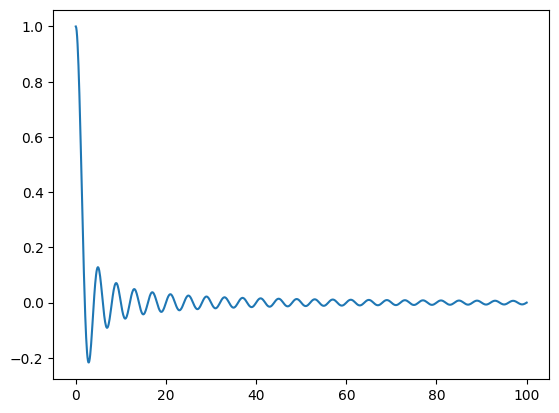

In [23]:
custom_sincp = 0.5
custom_nsamp = 1000  # To get the second pulse, I just simply increased the sampling

custom_t = np.linspace(0, dist_per_samp * custom_nsamp, custom_nsamp)
custom_y = list(wsrc(custom_t, custom_sincp))


plt.figure("General Estimate")
plt.plot(custom_t, custom_y)

2. X-limit for DAS algorithm:

No, we dont need to reconstruct the graph till Nsamp as the time delay/time per samp would easily exceed Nsamp.
A good limit would be Nsamp/2 as time delay/time per sample (for a mic which is straight in front of the obstacle) would be exactly Nsamp

3. Expected Position of Obstacle:

Yes, amplitude at (30,22) is good since if we convert it to the 2D space:

X coordinate = x * dist_per_samp=30 * 0.1=3

Y coordinate = -3.2+y * pitch = -3.2+2.2 = -1 (Interpolating from y=0 -> mic at (0,-3.2) and y=64 -> mic at (0,3.2))

4. Maximum possible coordinates:
The maximum x and y values we can take are:

X= nsamp*dist_per_samp/2 = 200*0.1/2=10 (the division by 2 has been explained in the second part)

Y= y coordinate of source+(nimcs*pitch)/2 = 0+64*0.1/2=3.2

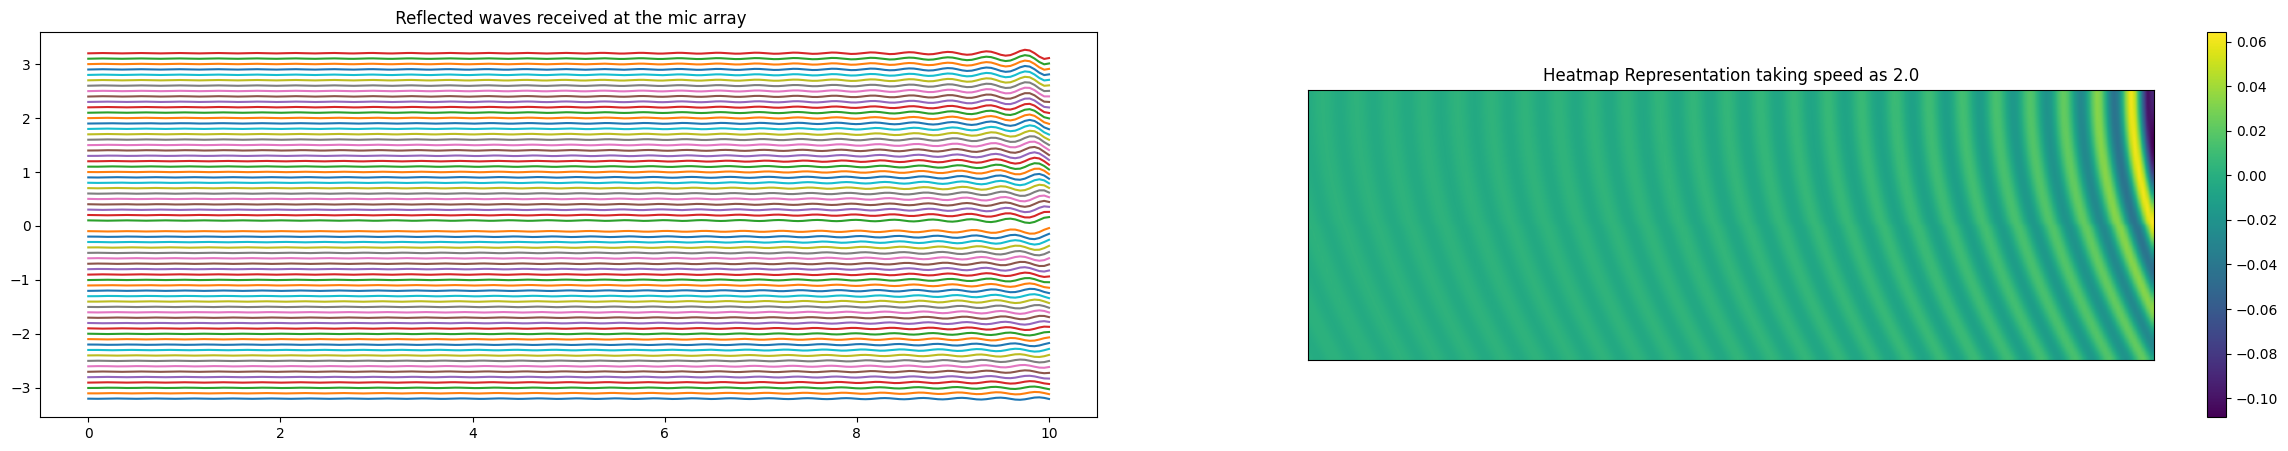

In [24]:
max_obs_loc = (10, 3.2)  # Calculation for this coordinate shown above
m = ultrasound(NMICS, SAMPLE_NO, PITCH, SPEED, max_obs_loc, SINCP, DIST_PER_SAMP, True)

5. Changing Speed

Lower speed means would mean the time between the samples become larger. This also means that the time duration at which you observe the peak intensity is  small compared to the overall time of observation. Hence, the graph would be sharper 

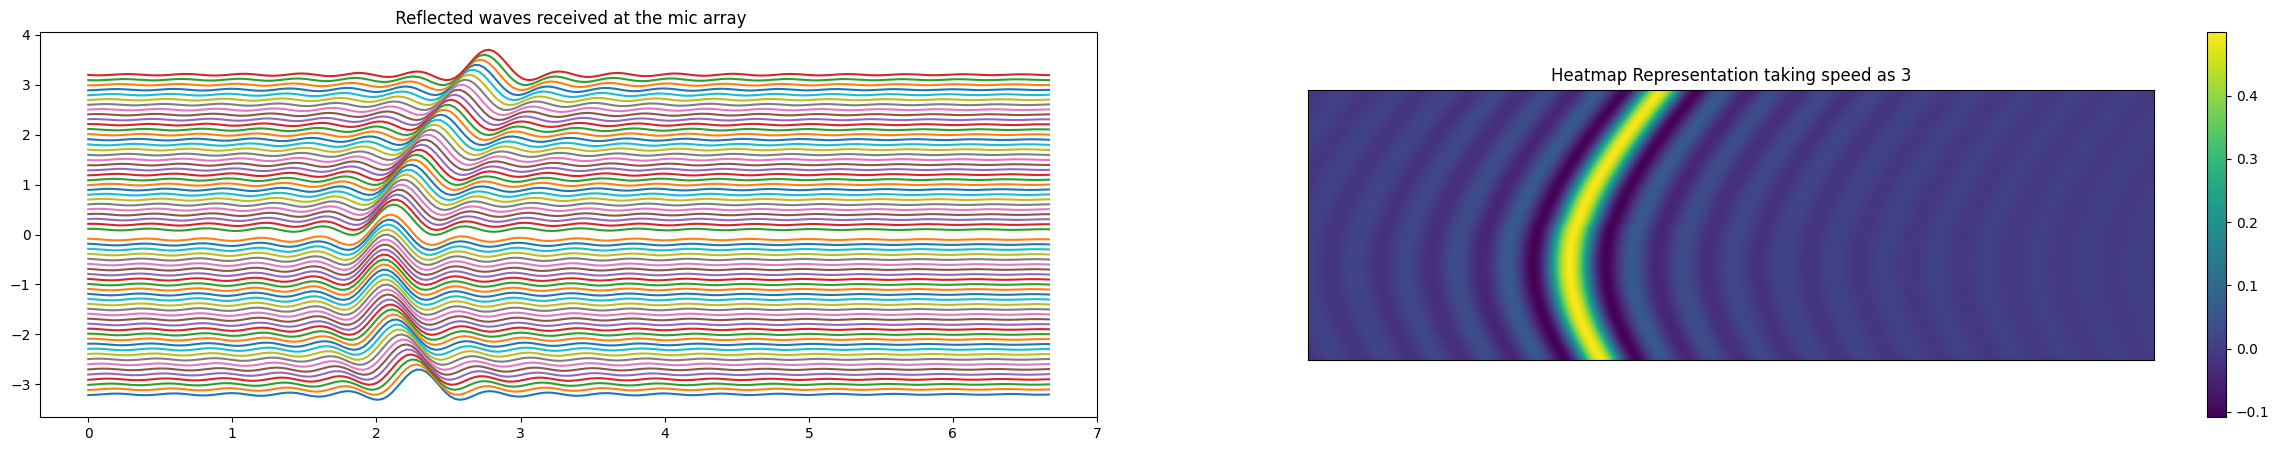

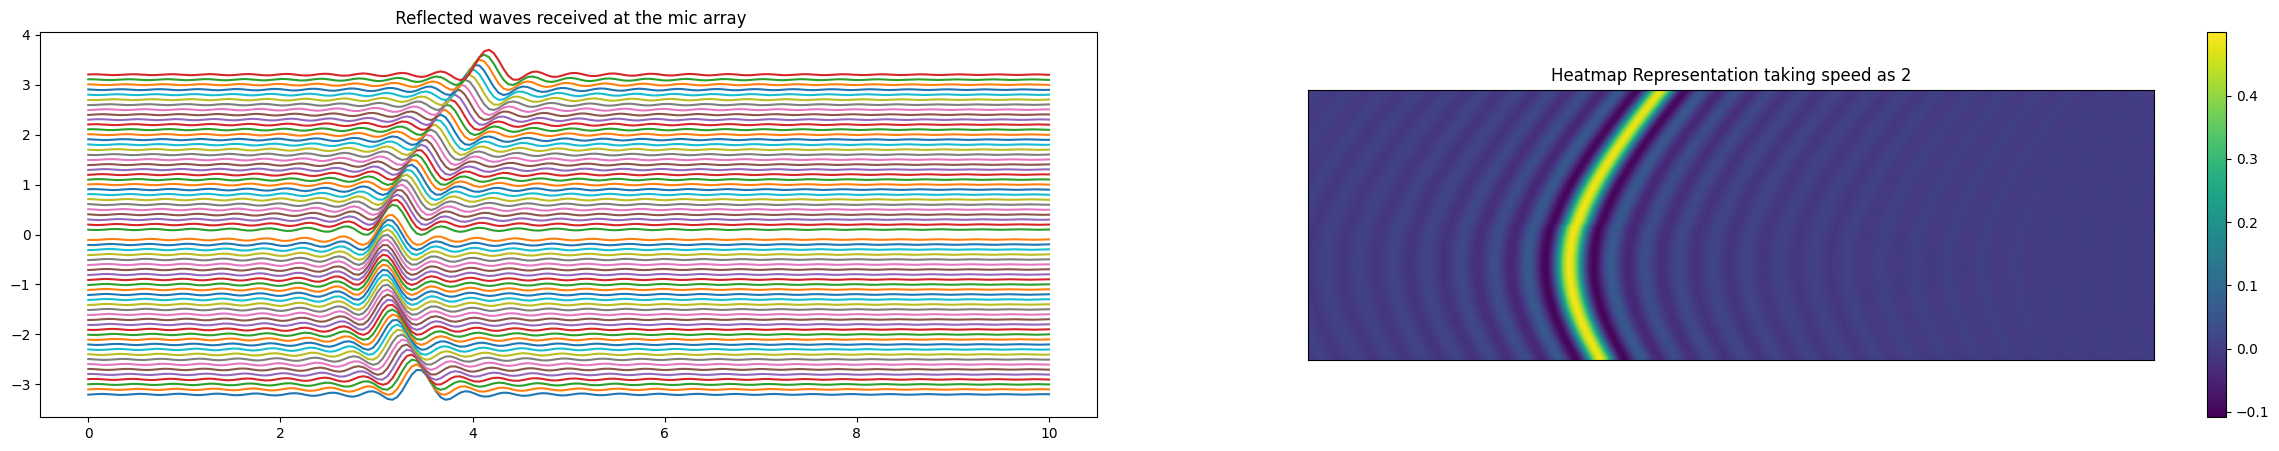

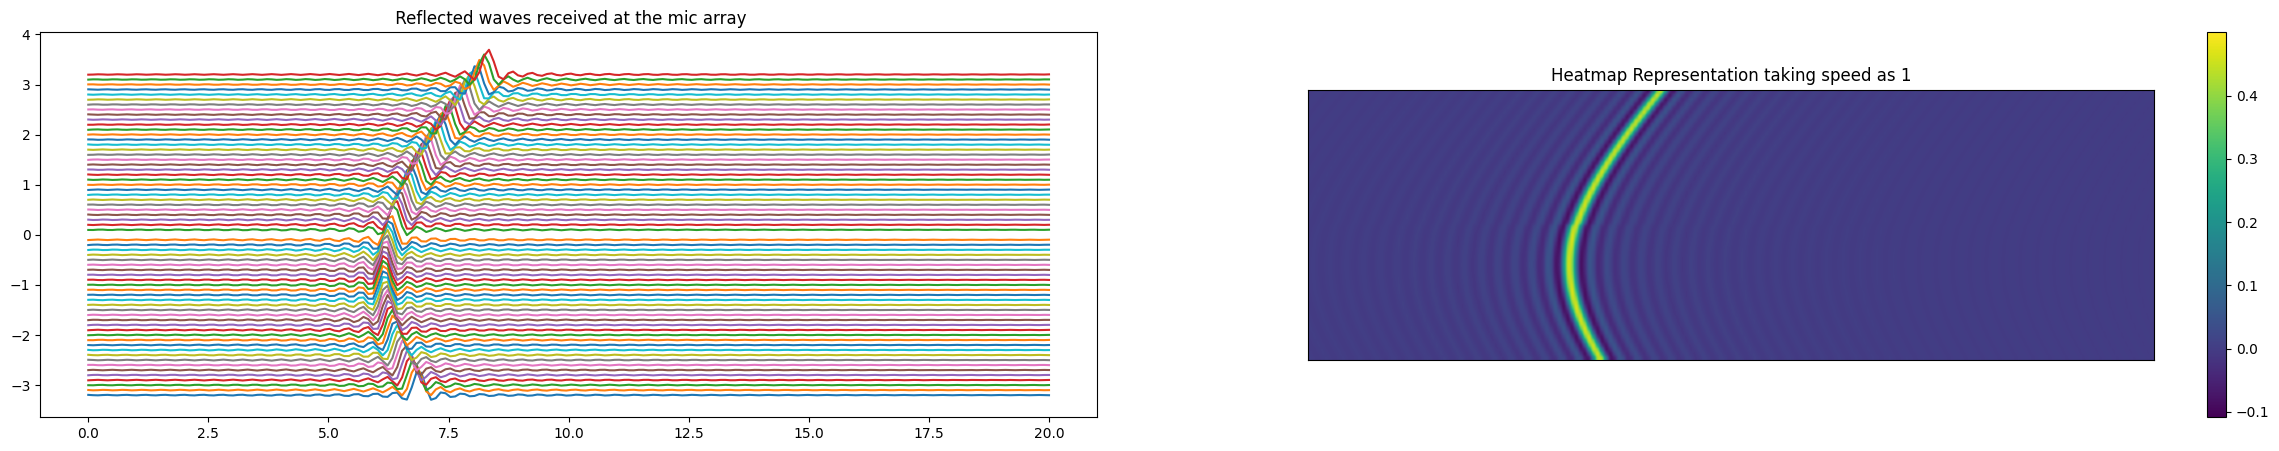

In [25]:
speed3 = 3
speed2 = 2
speed1 = 1

ult3 = ultrasound(NMICS, SAMPLE_NO, PITCH, speed3, OBS_LOC, SINCP, DIST_PER_SAMP, True)
ult2 = ultrasound(NMICS, SAMPLE_NO, PITCH, speed2, OBS_LOC, SINCP, DIST_PER_SAMP, True)
ult1 = ultrasound(NMICS, SAMPLE_NO, PITCH, speed1, OBS_LOC, SINCP, DIST_PER_SAMP, True)

6. Playing around with Nsamp and Nmics:

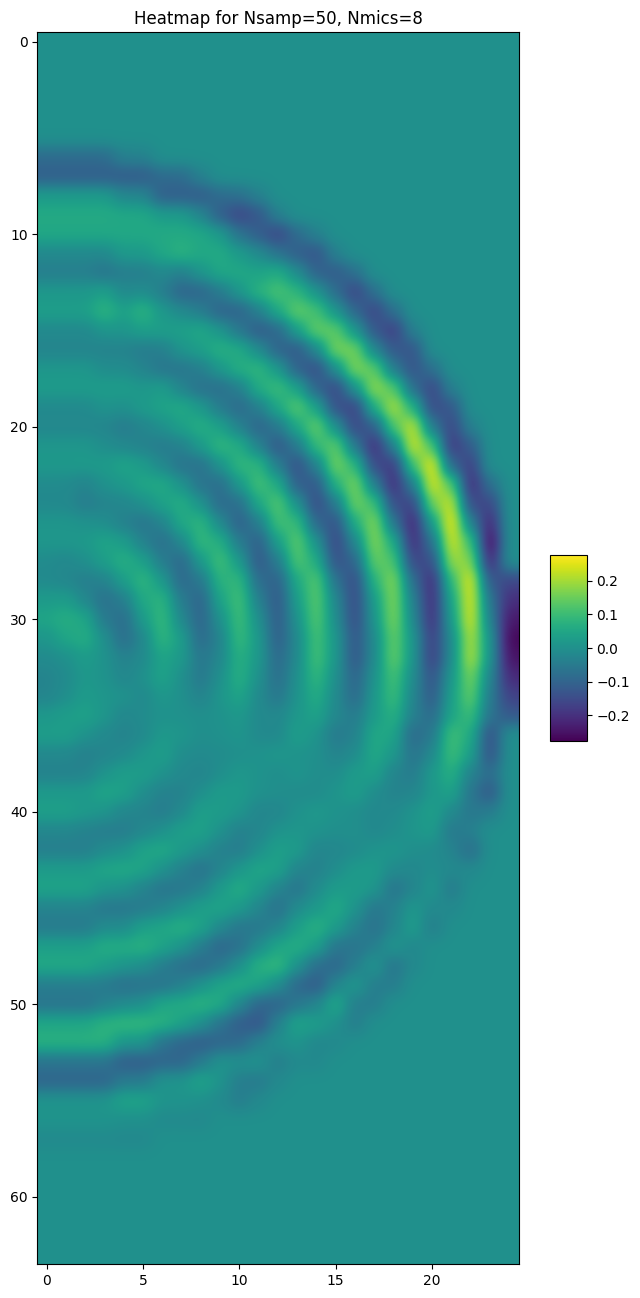

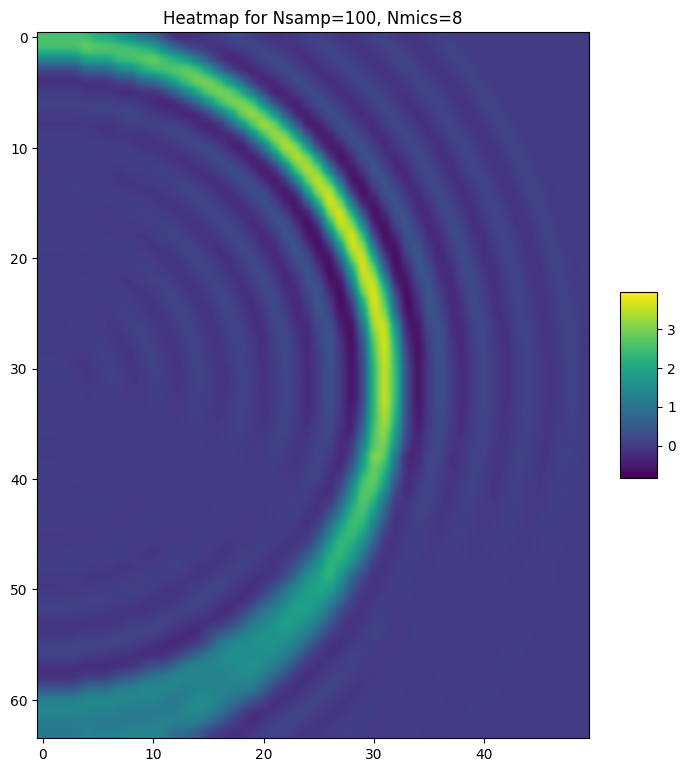

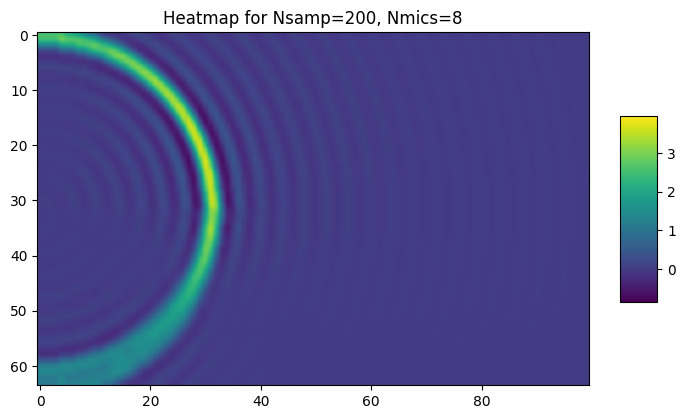

In [26]:
Nmics8 = 8
Nmics32 = 32
Nmics64 = 64

reconstruct(Nmics8, 0.1, li, 50, 0.1, 2)
reconstruct(Nmics8, 0.1, li, 100, 0.1, 2)
reconstruct(Nmics8, 0.1, li, 200, 0.1, 2)

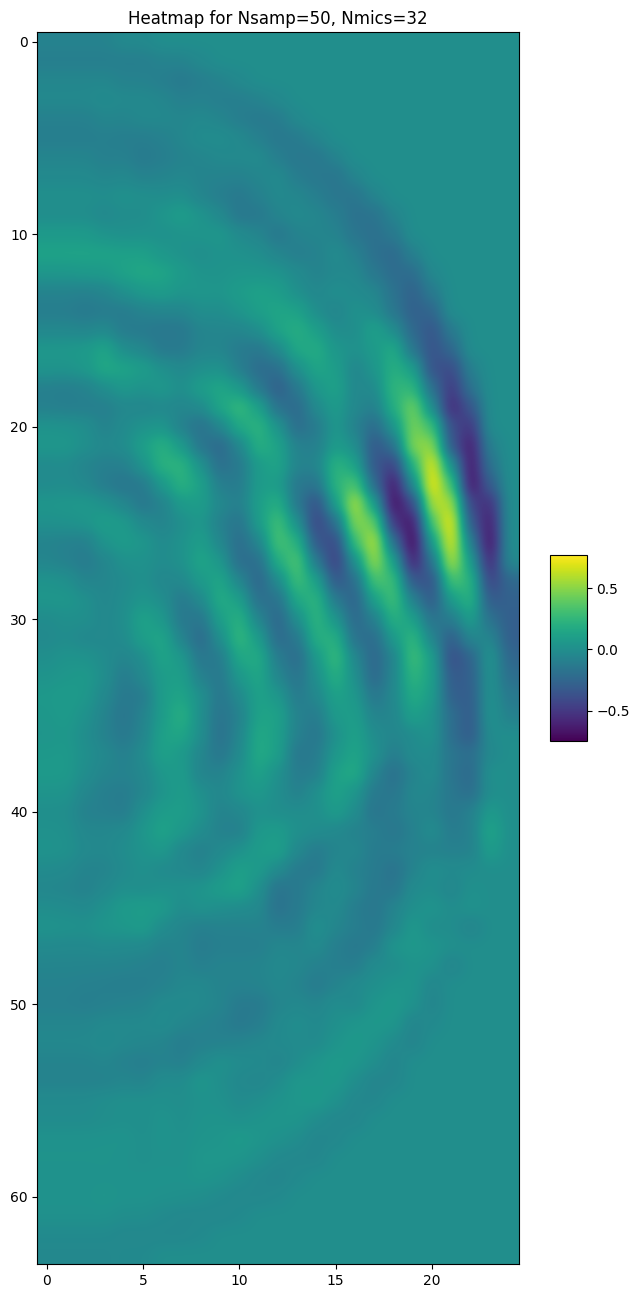

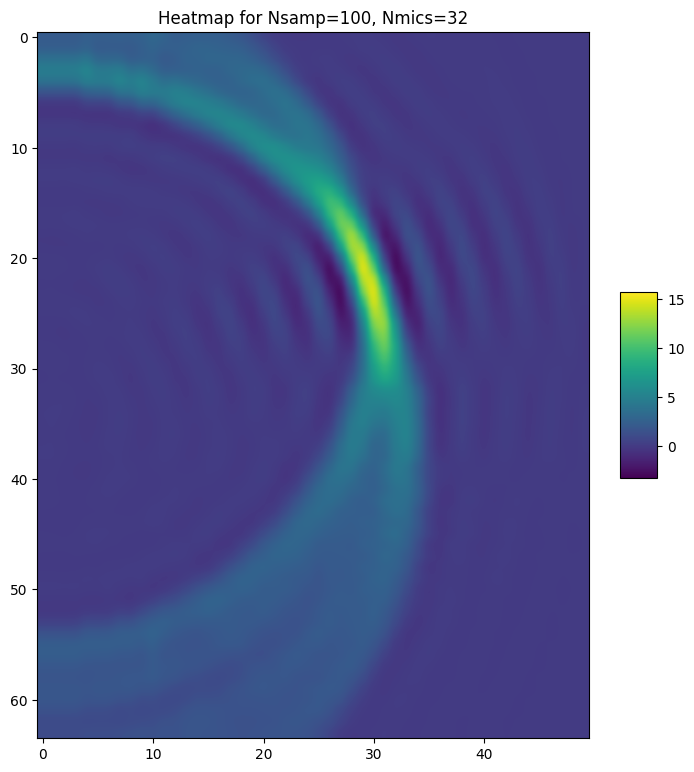

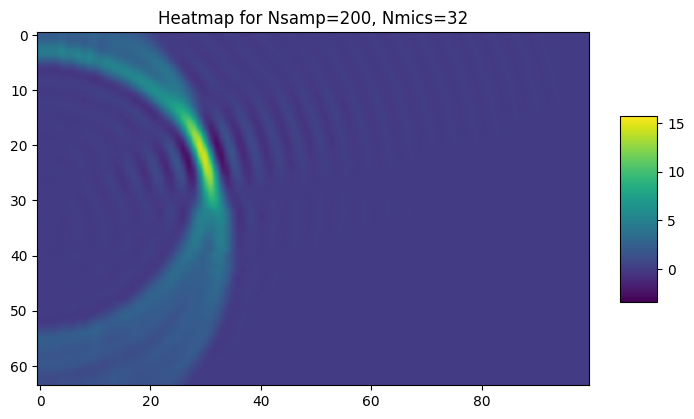

In [27]:
reconstruct(Nmics32, 0.1, li, 50, 0.1, 2)
reconstruct(Nmics32, 0.1, li, 100, 0.1, 2)
reconstruct(Nmics32, 0.1, li, 200, 0.1, 2)

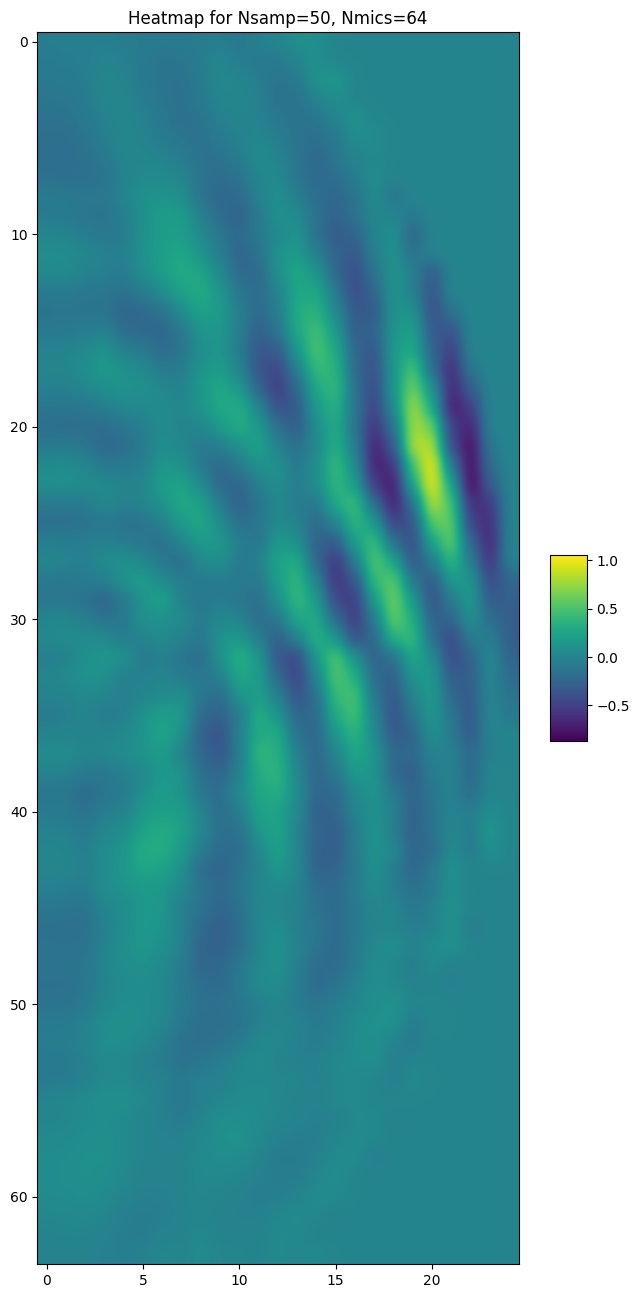

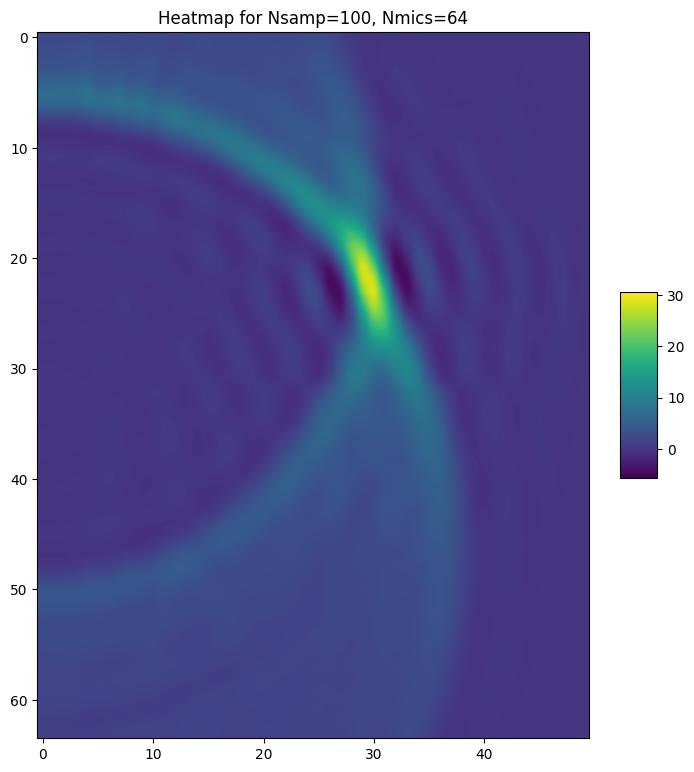

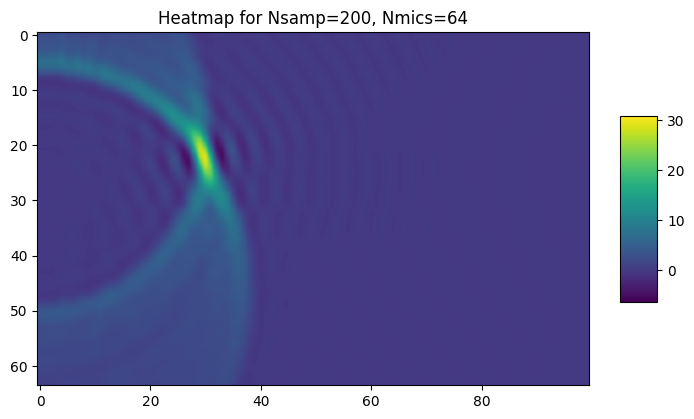

In [28]:
reconstruct(Nmics64, 0.1, li, 50, 0.1, 2)
reconstruct(Nmics64, 0.1, li, 100, 0.1, 2)
reconstruct(Nmics64, 0.1, li, 200, 0.1, 2)